# Оценка качества вин

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
import statsmodels.stats.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. **Modeling wine preferences by data mining from physicochemical properties.** *Decision Support Systems*, 47(4):547-553, 2009: имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10. 

Прочитаем данные:

In [45]:
wine = pd.read_csv('wine_data.csv', sep='\t', header=0)
wine = wine.sample(frac=1)

Вот так выглядит распределение экспертных оценок вин в выборке:

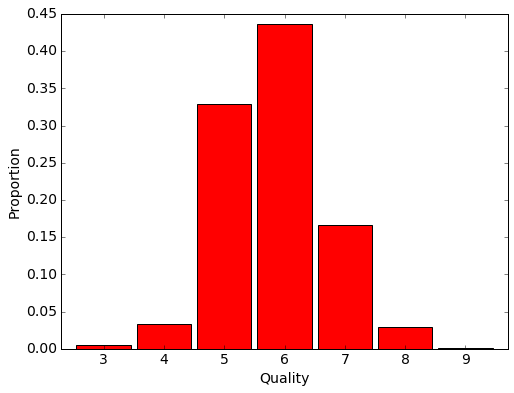

In [46]:
plt.figure(figsize(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Давайте научимся оценивать этот признак, чтобы мы могли заранее предположить, какую оценку получит какое-то новое вино, которого в выборке нет. 
Чтобы смоделировать такую ситуацию, отделим 25% выборки для контроля качества предсказания:

In [47]:
X_train, X_test, y_train, y_test = train_test_split(wine.ix[:, wine.columns != 'quality'], wine['quality'], test_size=0.25, 
                                                    stratify=wine[['Type', 'quality']])

In [48]:
X_train['Type'] = X_train['Type'].apply(lambda x : -1 if x == 'red' else 1)
X_test['Type'] = X_test['Type'].apply(lambda x : -1 if x == 'red' else 1)

Если у нас нет больше никакой информации о винах, то наше лучшее предположение об оценке — среднее имеющихся в обучающей выборке:

In [49]:
np.mean(y_train)

5.824302134646962

Если мы будем предсказывать этой величиной оценку всех вин, на обучающей выборке мы получим среднеквадратичную ошибку

In [50]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train))

0.87188368675543781

а на тестовой

In [51]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test))

0.88030932954759034

На тестовой выборке ошибка больше, поскольку среднее мы оценивали по обучающей. Это естественный эффект.

# Тип вина

Какая-то ещё информация у нас есть, например, о типе вина:

In [52]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

Распределения оценок по типам довольно сильно отличаются:

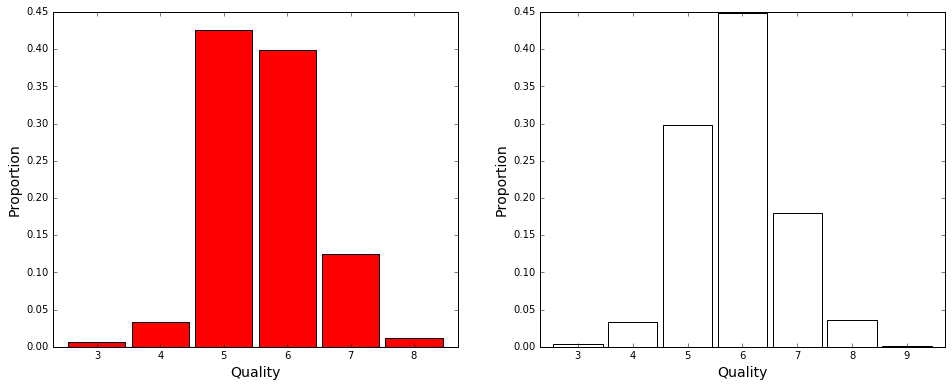

In [53]:
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot(color='w', kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Различие между средними статистически значимо:

In [54]:
tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['Type'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['Type'] == 'red']['quality']))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

4.8880690442015081e-22

95% доверительный интервал для разности средних оценок:

In [55]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.19293009404017963, 0.29084357932805199)

Чтобы уточнить наше предсказание, можно оценку каждого вина предсказывать средним по оценкам вин такого же типа в выборке:

In [56]:
regressor = LinearRegression()
regressor.fit(X_train['Type'].values.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
y_train_predictions = regressor.predict(X_train['Type'].values.reshape(-1,1))

In [58]:
y_test_predictions = regressor.predict(X_test['Type'].values.reshape(-1,1))

Ошибки предсказания немного уменьшились:

In [59]:
sqrt(mean_squared_error(y_train_predictions, y_train))

0.86515602249918166

In [60]:
sqrt(mean_squared_error(y_test_predictions, y_test))

0.8771823059885907

Вот так выглядят истинные оценки вин и их предсказания средними по типам на тестовой выборке:

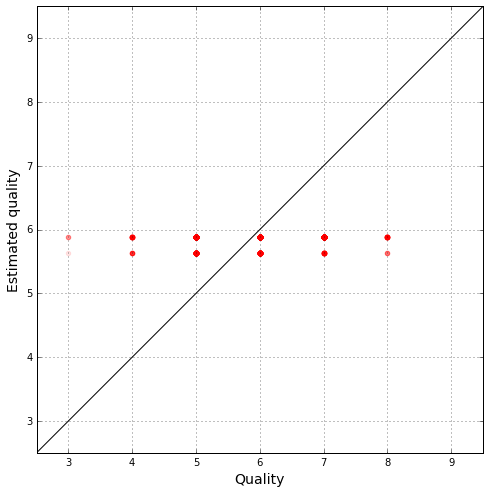

In [61]:
pyplot.figure(figsize(8,8))
pyplot.scatter(y_test, y_test_predictions, color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

# Другие признаки

На самом деле у нас есть ещё 11 признаков, описывающих химический состав вин:

In [62]:
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
4301,white,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5
4701,white,6.5,0.29,0.26,7.0,0.040,18.0,113.0,0.99366,3.17,0.38,10.2,6
3646,white,6.8,0.34,0.44,6.6,0.052,28.0,156.0,0.99550,3.14,0.41,9.6,5
4194,white,8.2,0.52,0.34,1.2,0.042,18.0,167.0,0.99366,3.24,0.39,10.6,5
3827,white,7.1,0.20,0.36,11.6,0.042,45.0,124.0,0.99700,2.92,0.59,9.5,7


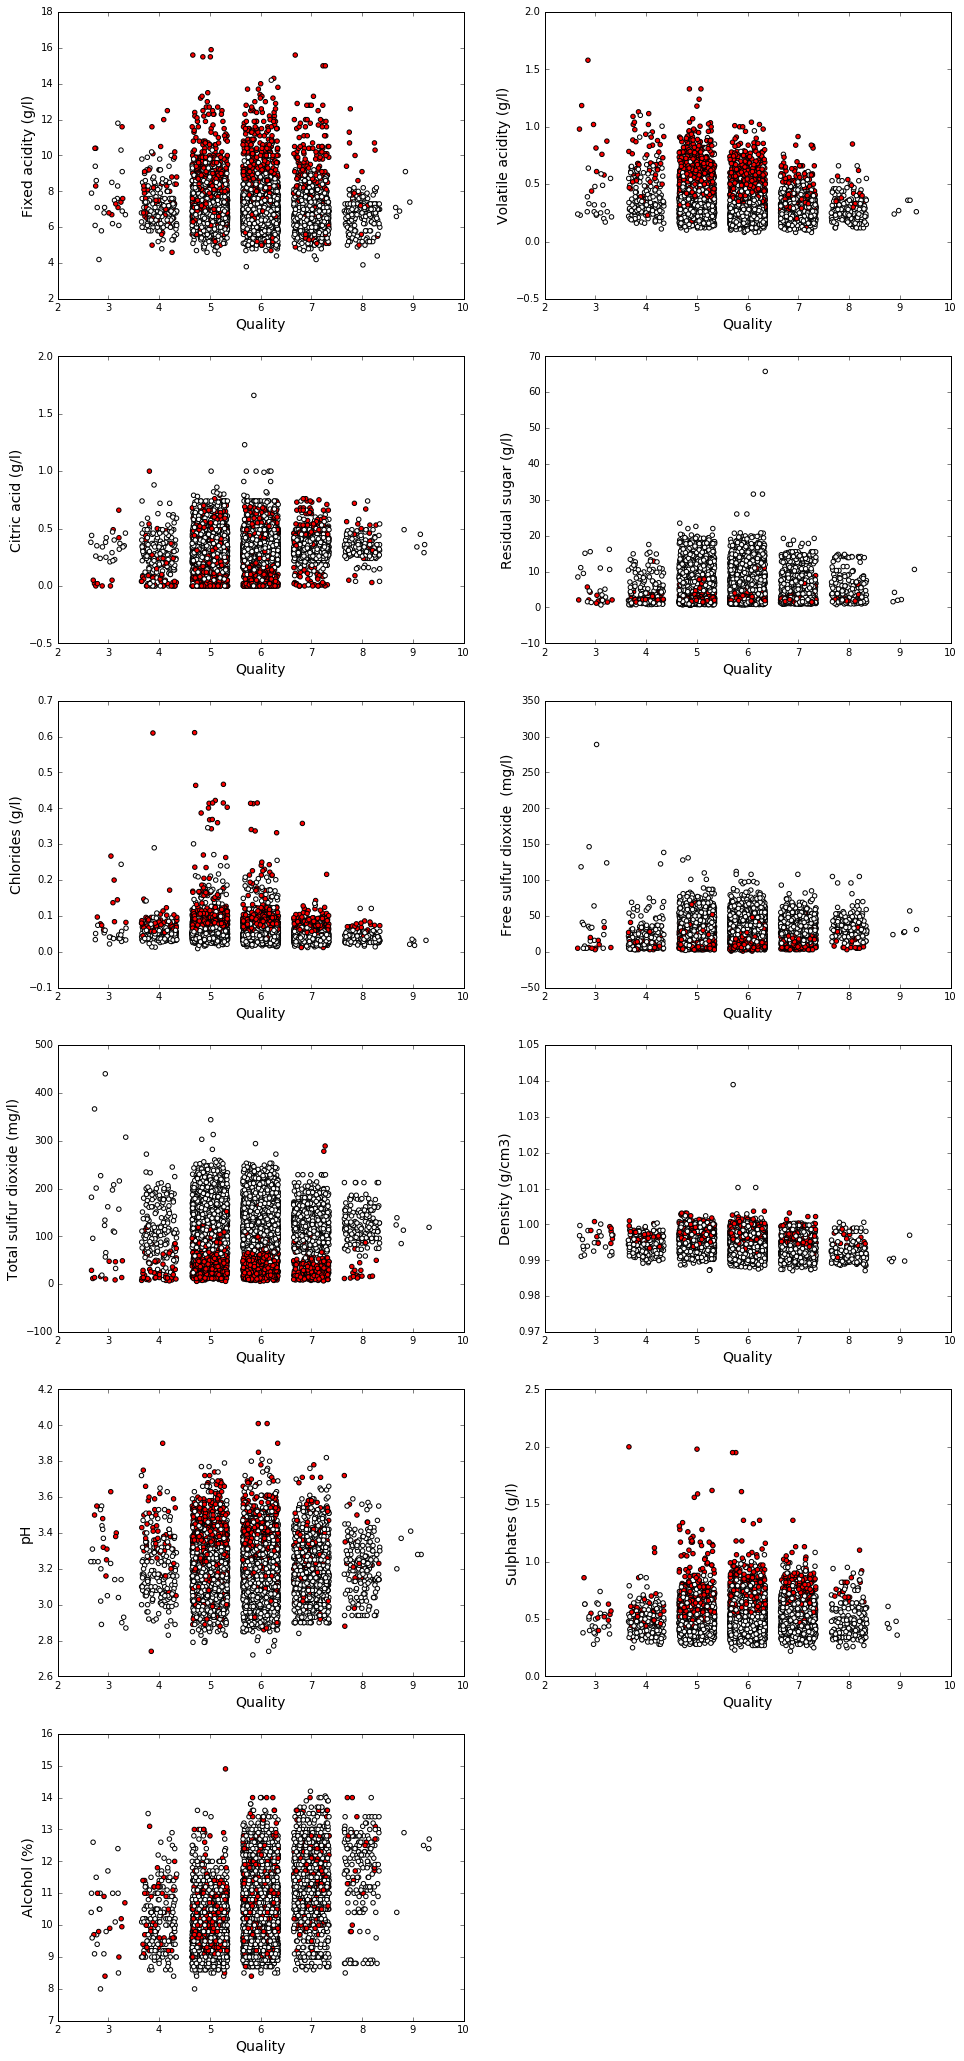

In [63]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, 12):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(wine['quality']), wine.ix[:, i], color=wine["Type"], edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(wine.columns[i]), fontsize=14)

Попробуем их учесть при построении прогноза оценок.

## Линейная регрессия

Построим для начала линейную регрессионную модель.

In [64]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Ошибки предсказания существенно уменьшились:

In [65]:
sqrt(mean_squared_error(lm.predict(X_train), y_train))

0.72844550347994474

In [66]:
sqrt(mean_squared_error(lm.predict(X_test), y_test))

0.73321408244907205

Истинные оценки вин и их предсказания линейной моделью:

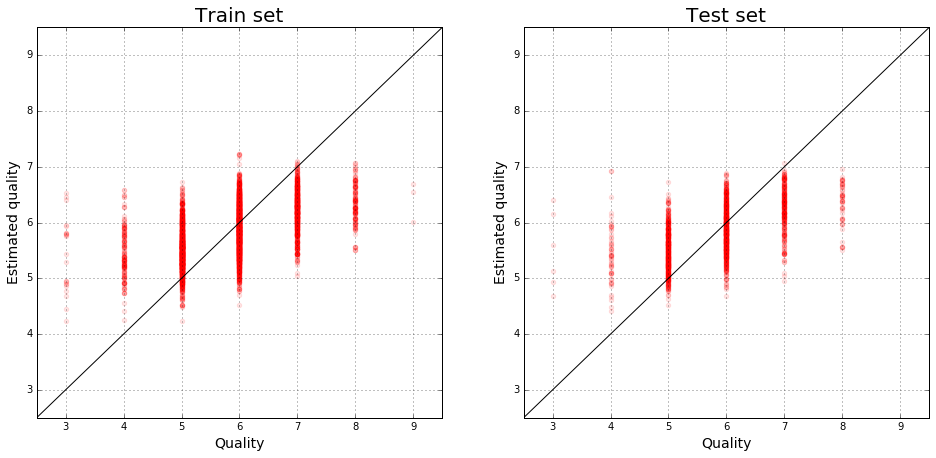

In [67]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Посчитаем коэффициент детерминации — долю объяснённой моделью дисперсии отклика:

In [68]:
lm.score(X_test, y_test)

0.30611257316718898

## Случайный лес

Построим на обучающей выборке случайный лес:

In [69]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)

In [70]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Качество выросло ещё сильнее, хотя модель и переобучилась:

In [71]:
sqrt(mean_squared_error(rf.predict(X_train), y_train))

0.30884065475615402

In [72]:
sqrt(mean_squared_error(rf.predict(X_test), y_test))

0.55290274288983621

Истинные оценки вин и их предсказания случайным лесом:

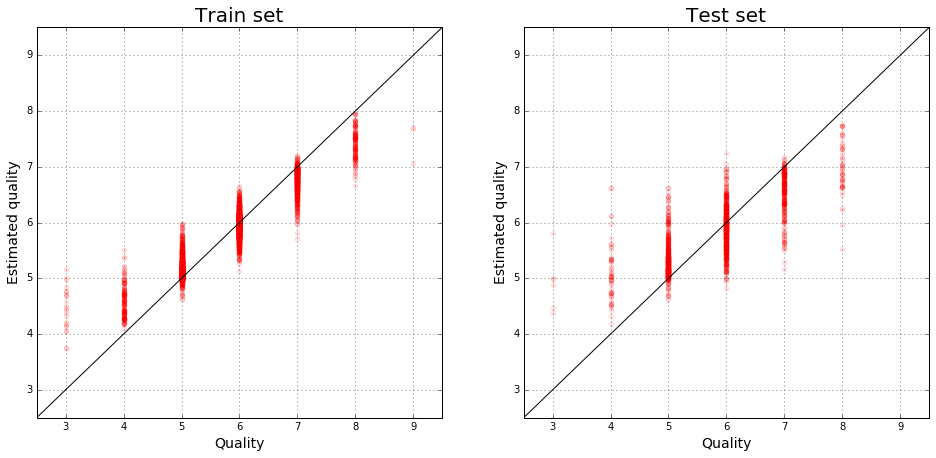

In [73]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Коэффициент детерминации для случайного леса:

In [74]:
rf.score(X_test, y_test)

0.60542922778652775

Сравним ошибки линейной регрессии и случайного леса на тестовой выборке:

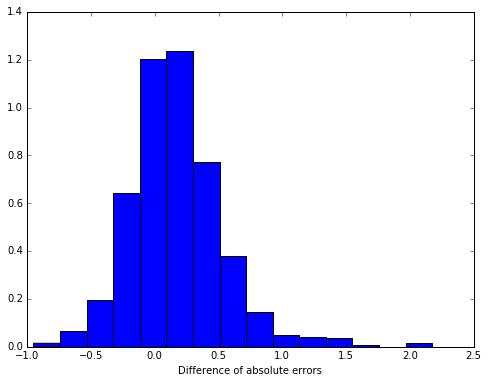

In [75]:
plt.figure(figsize(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15, normed=True)
plt.xlabel('Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [76]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

1.8888905672004704e-28

95% доверительный интервал для средней разности абсолютных ошибок:

In [77]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.13788150504674029, 0.19659702472945545)

То есть, используя вместо линейной регрессии наш случайный лес, мы предсказываем экспертную оценку в среднем на 0.26-0.30 баллов точнее.

Давайте посмотрим, какие признаки обладают наибольшей предсказательной способностью:

In [78]:
importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
11,Alcohol (%),0.276707
2,Volatile acidity (g/l),0.135079
6,Free sulfur dioxide (mg/l),0.084062
10,Sulphates (g/l),0.080023
7,Total sulfur dioxide (mg/l),0.073588
4,Residual sugar (g/l),0.063734
5,Chlorides (g/l),0.061545
9,pH,0.059845
3,Citric acid (g/l),0.057833
8,Density (g/cm3),0.054111


Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя.